# load packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning and info message
import numpy
import jax
import tensorflow as tf
import tensorflow_datasets as tfds
import jax.numpy as jnp
import numpy as np
import neural_tangents as nt
from neural_tangents import stax

from tqdm import tqdm
from PIL import Image
from jax import jit, grad, hessian
from jax import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

import random
from collections import Counter

import time
import gc
import glob
from sklearn.preprocessing import OneHotEncoder

from jax.experimental.stax import logsoftmax

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-08-10 21:00:33.522698: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.10.0
Num GPUs Available:  4


In [2]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=False
%env JAX_ENABLE_X64=True
%matplotlib inline

env: XLA_PYTHON_CLIENT_PREALLOCATE=False
env: JAX_ENABLE_X64=True


In [3]:
from jax.config import config
config.update("jax_enable_x64", True)

# specify which GPU

In [4]:
# specify which GPU of jax (NTK)
from functools import partial
jit = partial(jit, device = jax.devices("gpu")[2])

In [5]:
# specify which GPU of tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
#     tf.config.experimental.set_visible_devices([], "GPU")

4 Physical GPUs, 1 Logical GPUs


# Load dataset

In [6]:
def shuffle_data(images, labels, seed=None):
    perm = np.random.RandomState(seed).permutation(images.shape[0])
    images = images[perm]
    labels = labels[perm]
    return images, labels

def standardization_and_normalization(data, name='cifar10'):
    if name == 'cifar10' or name == 'svhn_cropped':
        mean = np.mean(data, axis=(1, 2)).reshape(-1,1,1,3) # per-channel
        std = np.std(data, axis=(1, 2)).reshape(-1,1,1,3) # per-channel
        standardized_data = (data - mean) / std

        _min = np.min(standardized_data, axis=(1, 2)).reshape(-1,1,1,3) # per-channel
        _max = np.max(standardized_data, axis=(1, 2)).reshape(-1,1,1,3) # per-channel

        return (standardized_data - _min) / (_max-_min)
    
    elif name == 'mnist' or name == 'fashion_mnist':
        mean = np.mean(data, axis=(1, 2)).reshape(-1,1,1,1) # per-channel
        std = np.std(data, axis=(1, 2)).reshape(-1,1,1,1) # per-channel
        standardized_data = (data - mean) / std

        _min = np.min(standardized_data, axis=(1, 2)).reshape(-1,1,1,1) # per-channel
        _max = np.max(standardized_data, axis=(1, 2)).reshape(-1,1,1,1) # per-channel

        return (standardized_data - _min) / (_max-_min)

def encoding(label):
    classes = np.unique(label)
    encoded_label = np.array(label[:, None] == np.arange(len(classes)), dtype=np.float32)
    return encoded_label - 1 / len(classes)

def get(X, Y, num):
    output = list()
    check = dict()
    classes = np.unique(Y)
    Y = np.array(Y)

    for i in range(len(Y)):
        check.setdefault(Y[i], set())
        if len(check[Y[i]]) < num:
            check[Y[i]].add(i)
    for idx in check.values():
        output.extend(list(idx))
    return output

def load_dataset(name='cifar10', download=False, data_dir='~', batch_size=-1, seed=0, num_per_class_train=20, num_per_class_test=10):
    if name == 'svhn_cropped_gray':
        dataset = tfds.load(name='svhn_cropped', download=download, data_dir=data_dir, batch_size=batch_size)
    else:
        dataset = tfds.load(name=name, download=download, data_dir=data_dir, batch_size=batch_size)
        # dataset = tfds.load(name=name, download=download, data_dir='/opt/shared-disk2/YuHung/', batch_size=batch_size)

    dataset_numpy = tfds.as_numpy(dataset)
    image_width = dataset_numpy['train']['image'].shape[1]
    channel = dataset_numpy['train']['image'].shape[-1]
    x_train, y_train, x_test, y_test = np.array(dataset['train']['image']).reshape(-1, channel, image_width, image_width), np.array(dataset['train']['label']), \
                                       np.array(dataset['test']['image']).reshape(-1, channel, image_width, image_width), np.array(dataset['test']['label'])
    
    x_train, y_train = shuffle_data(x_train, y_train, seed)
    x_test, y_test = shuffle_data(x_test, y_test, seed)
    
    train_choice = get(x_train, y_train, num_per_class_train)
    test_choice = get(x_test, y_test, num_per_class_test)
    
    x_train, y_train = np.array([x_train[i] for i in train_choice], dtype=np.float32), np.array([y_train[i] for i in train_choice], dtype=np.float32)
    x_test, y_test = np.array([x_test[i] for i in test_choice], dtype=np.float32), np.array([y_test[i] for i in test_choice], dtype=np.float32)
    
    if name == 'mnist' or name == 'fashion_mnist':
        x_train = x_train.reshape(-1, 28, 28, 1)
        x_test = x_test.reshape(-1, 28, 28, 1)
    elif name == 'cifar10' or name == 'svhn_cropped':
        x_train = x_train.reshape(-1, 32, 32, 3)
        x_test = x_test.reshape(-1, 32, 32, 3)
    elif name == 'svhn_cropped_gray':
        x_train = x_train[:,:,:,0].reshape(-1, 32, 32, 1)
        x_test = x_test[:,:,:,0].reshape(-1, 32, 32, 1)
    
    print("Before mean:", x_train.mean(), x_test.mean())
    x_train, x_test = standardization_and_normalization(x_train, name), standardization_and_normalization(x_test, name)
    print("After mean:", x_train.mean(), x_test.mean())
    
    y_train, y_test = encoding(y_train), encoding(y_test)
    
    return x_train, y_train, x_test, y_test

In [7]:
# x_train, y_train, x_test, y_test = load_dataset(name='mnist', seed = 0, num_per_class_train = 200, num_per_class_test=10)

dataset = 'cifar10'
x_train, y_train, x_test, y_test = load_dataset(name=dataset, seed = 1, num_per_class_train = 100, num_per_class_test=100)
# x_train, y_train, x_test, y_test = load_dataset(name=dataset, seed = 1, num_per_class_train = 50, num_per_class_test=50)
# x_train, y_train, x_test, y_test = load_dataset(name='svhn_cropped_gray', download=False, data_dir='/mnt/large-disk/YuHung/', seed = 1, num_per_class_train = 50, num_per_class_test=50)

# or set download=True to download the dataset to `data_dir`
# x_train, y_train, x_test, y_test = load_dataset(name=dataset, download=True, data_dir='./dataset/', seed = 1, num_per_class_train = 50, num_per_class_test=50)


print(f'Training data shape: {x_train.shape}, {y_train.shape}\n'
      f'Testing data shape: {x_test.shape}, {y_test.shape}')

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Before mean: 120.501 119.36736
After mean: 0.4862345 0.47723022
Training data shape: (1000, 32, 32, 3), (1000, 10)
Testing data shape: (1000, 32, 32, 3), (1000, 10)


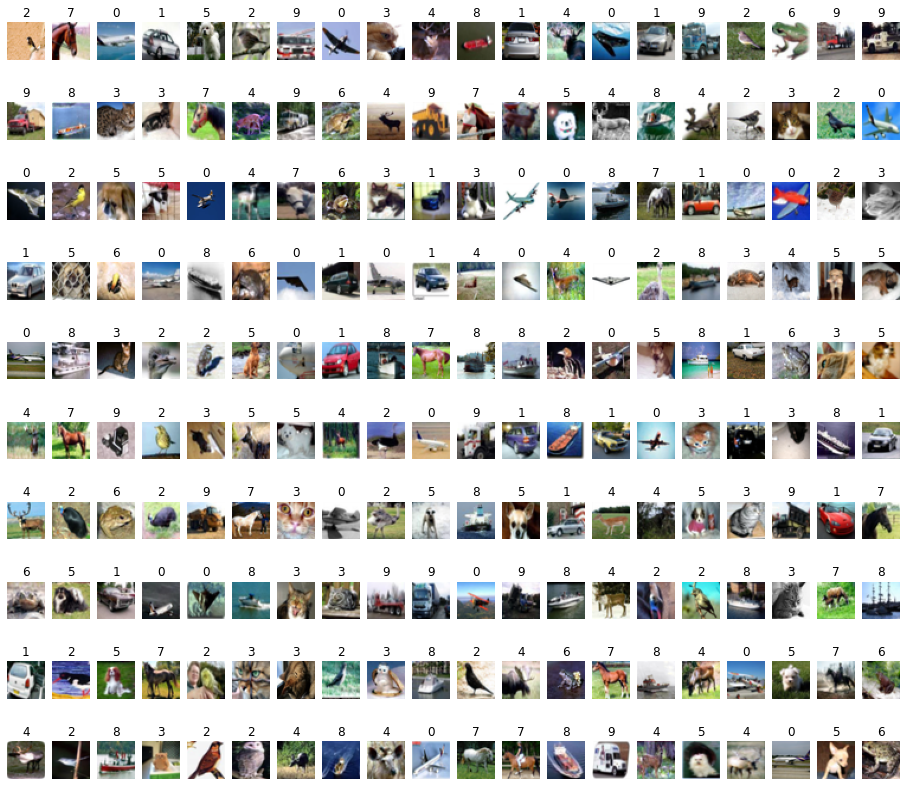

In [8]:
fig = plt.figure(figsize=(16, 16))
x_train, y_train = shuffle_data(x_train, y_train, seed=0)
for idx, (img, label) in enumerate(zip(x_train[:200], y_train[:200])):
    plt.subplot(20, 20, idx+1)
    plt.subplots_adjust(top=1.5)
    plt.imshow(img, cmap='gray')
    plt.title(f'{np.argmax(label)}')
    plt.axis('off')

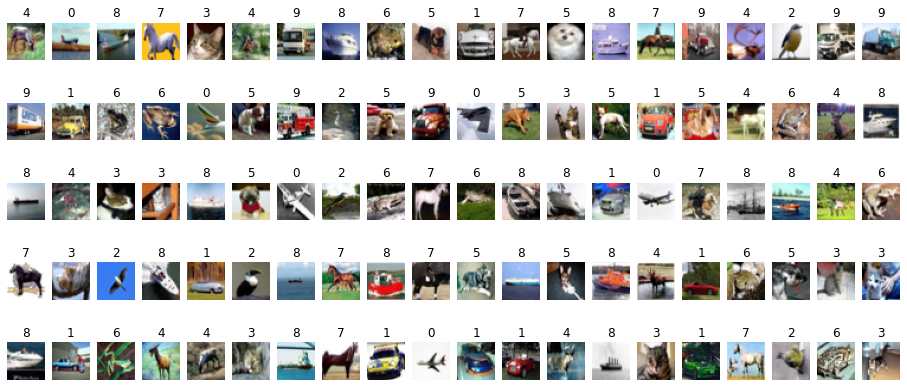

In [9]:
fig = plt.figure(figsize=(16, 16))
x_test, y_test = shuffle_data(x_test, y_test, seed=0)
for idx, (img, label) in enumerate(zip(x_test[:100], y_test[:100])):
    plt.subplot(20, 20, idx+1)
    plt.subplots_adjust(top=1.5)
    plt.imshow(img, cmap='gray')
    plt.title(f'{np.argmax(label)}')
    plt.axis('off')

In [10]:
# ### if NTK simulate FNN
# if dataset == 'mnist' or dataset == 'fashion_mnist':
#     x_train = x_train.reshape(-1, 784)
#     x_test = x_test.reshape(-1, 784)
# elif dataset == 'cifar10' or dataset == 'svhn_cropped':
#     x_train = x_train.reshape(-1, 3072)
#     x_test = x_test.reshape(-1, 3072)
# elif dataset == 'svhn_cropped_gray':
#     x_train = x_train.reshape(-1, 1024)
#     x_test = x_test.reshape(-1, 1024)

print(f'Training data shape: {x_train.shape}, {y_train.shape}\n'
      f'Testing data shape: {x_test.shape}, {y_test.shape}')

Training data shape: (1000, 32, 32, 3), (1000, 10)
Testing data shape: (1000, 32, 32, 3), (1000, 10)


# load pretrained VGG

In [11]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

def erf_activation(x):
    return tf.math.erf(x)

get_custom_objects().update({'erf_activation': Activation(erf_activation)})

In [12]:
if dataset == 'mnist' or dataset == 'fashion_mnist':
    input_shape = (784,)
elif dataset == 'cifar10' or dataset == 'svhn_cropped':
    input_shape = (3072,)
elif dataset == 'svhn_cropped_gray':
    input_shape = (1024,)

model = tf.keras.Sequential()
model.add(tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096))
model.add(tf.keras.layers.Dense(4096))
model.add(tf.keras.layers.Dense(10))
model.summary()
model.save_weights('NTK-VGG16_init.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 10)                40970     
                                                                 
Total params: 33,638,218
Trainable params: 33,638,218
Non-trainable params: 0
_________________________________________________________________


# load black-box attacks

## black-box attack using "clean_train_from_scratch" as substitute model

In [13]:
model.load_weights('clean_train_from_scratch_20w.h5')

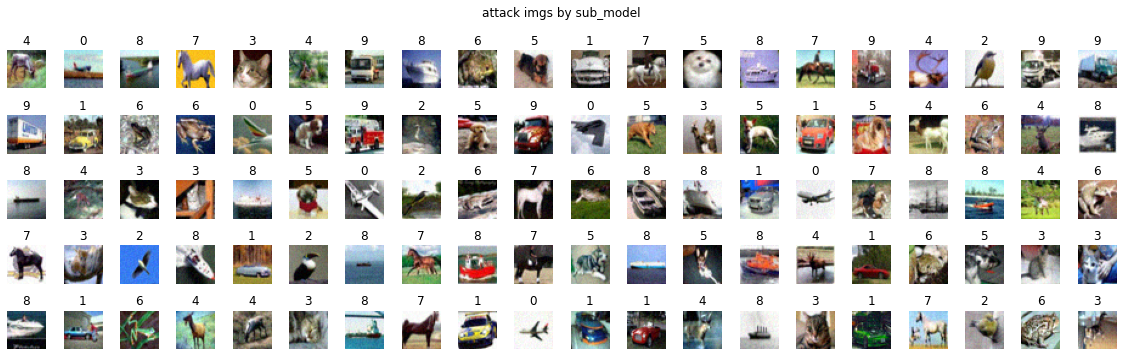

In [14]:
sub_adv_img = fast_gradient_method(model, x_test, 0.03, np.inf, clip_min=0.0, clip_max=1.0)
if dataset == 'mnist' or dataset == 'fashion_mnist':
    x_show = np.array(sub_adv_img).reshape(-1, 28, 28, 1)
elif dataset == 'cifar10' or dataset == 'svhn_cropped':
    x_show = np.array(sub_adv_img).reshape(-1, 32, 32, 3)
elif dataset == 'svhn_cropped_gray':
    x_show = np.array(sub_adv_img).reshape(-1, 32, 32, 1)

y_show = y_test

fig = plt.figure(figsize=(16, 5))
fig.suptitle('attack imgs by sub_model')
for idx, (img, label) in enumerate(zip(x_show[:100], y_show[:100])):
    plt.subplot(5, 20, idx+1)
    plt.subplots_adjust(top=0.5)
    plt.imshow(img, cmap='gray')
    plt.title(f'{np.argmax(label)}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
clean_train_from_scratch_x, clean_train_from_scratch_y = sub_adv_img, y_test

## black-box attack using "adv_train_from_scratch_20w" as substitute model

In [16]:
model.load_weights('adv_train_from_scratch_20w.h5')

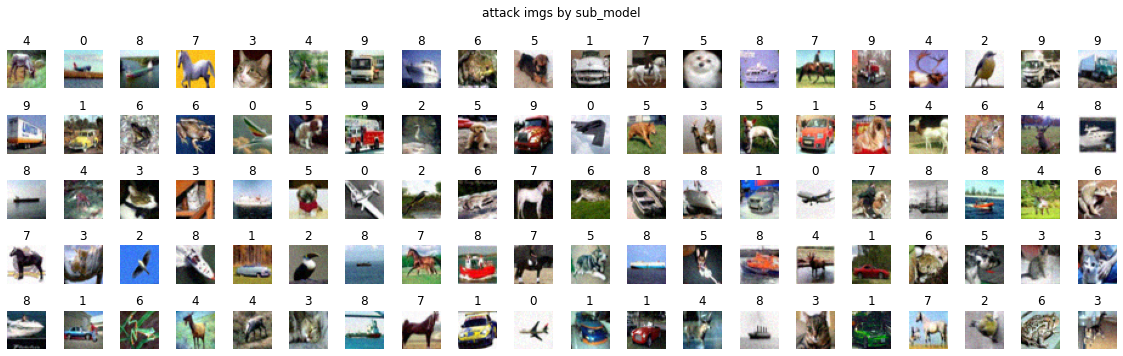

In [17]:
sub_adv_img = fast_gradient_method(model, x_test, 0.03, np.inf, clip_min=0.0, clip_max=1.0)
if dataset == 'mnist' or dataset == 'fashion_mnist':
    x_show = np.array(sub_adv_img).reshape(-1, 28, 28, 1)
elif dataset == 'cifar10' or dataset == 'svhn_cropped':
    x_show = np.array(sub_adv_img).reshape(-1, 32, 32, 3)
elif dataset == 'svhn_cropped_gray':
    x_show = np.array(sub_adv_img).reshape(-1, 32, 32, 1)

y_show = y_test

fig = plt.figure(figsize=(16, 5))
fig.suptitle('attack imgs by sub_model')
for idx, (img, label) in enumerate(zip(x_show[:100], y_show[:100])):
    plt.subplot(5, 20, idx+1)
    plt.subplots_adjust(top=0.5)
    plt.imshow(img, cmap='gray')
    plt.title(f'{np.argmax(label)}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
adv_train_from_scratch_x, adv_train_from_scratch_y = sub_adv_img, y_test

## black-box attack using "CFT_1k" as substitute model

In [19]:
model.load_weights('CFT_1k.h5')

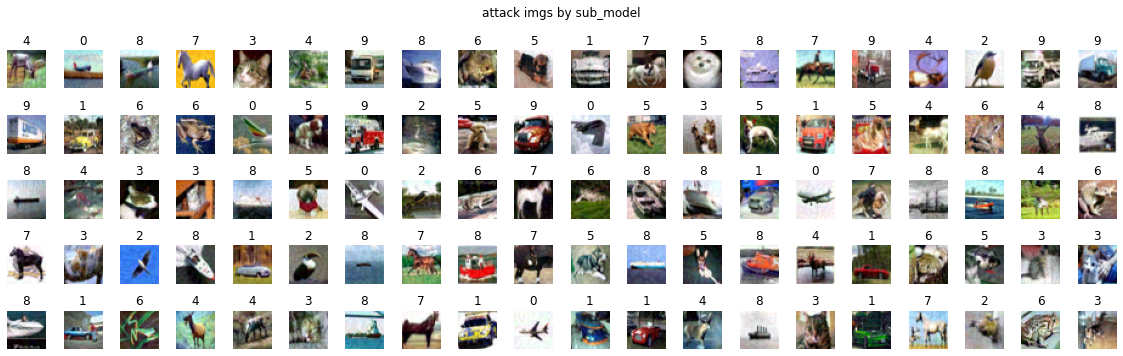

In [20]:
sub_adv_img = fast_gradient_method(model, x_test, 0.03, np.inf, clip_min=0.0, clip_max=1.0)
if dataset == 'mnist' or dataset == 'fashion_mnist':
    x_show = np.array(sub_adv_img).reshape(-1, 28, 28, 1)
elif dataset == 'cifar10' or dataset == 'svhn_cropped':
    x_show = np.array(sub_adv_img).reshape(-1, 32, 32, 3)
elif dataset == 'svhn_cropped_gray':
    x_show = np.array(sub_adv_img).reshape(-1, 32, 32, 1)

y_show = y_test

fig = plt.figure(figsize=(16, 5))
fig.suptitle('attack imgs by sub_model')
for idx, (img, label) in enumerate(zip(x_show[:100], y_show[:100])):
    plt.subplot(5, 20, idx+1)
    plt.subplots_adjust(top=0.5)
    plt.imshow(img, cmap='gray')
    plt.title(f'{np.argmax(label)}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
CFT_x, CFT_y = sub_adv_img, y_test

# Adversarial Fine-tune using NTK-attack

## define NTK

#### define NTK architecture

In [22]:
from neural_tangents import stax

b_std, W_std = 0.1, np.sqrt(2)
neurons = 1024

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Conv(out_chan=64, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.Conv(out_chan=64, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
    stax.Conv(out_chan=128, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.Conv(out_chan=128, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
    stax.Conv(out_chan=256, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.Conv(out_chan=256, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.Conv(out_chan=256, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
    stax.Conv(out_chan=512, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.Conv(out_chan=512, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.Conv(out_chan=512, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
    stax.Conv(out_chan=512, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.Conv(out_chan=512, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.Conv(out_chan=512, filter_shape=(3, 3), padding='SAME', W_std=W_std, b_std=b_std), stax.Relu(),
    stax.AvgPool(window_shape=(2, 2), strides=(2, 2), padding='VALID'),
    stax.Flatten(),
    stax.Dense(4096, W_std, b_std), stax.Relu(),
    stax.Dense(4096, W_std, b_std), stax.Relu(),
    stax.Dense(10, W_std, b_std)    
    
#     stax.Dense(neurons, W_std, b_std), stax.Erf(),
#     stax.Dropout(0.2),
#     stax.Dense(neurons, W_std, b_std), stax.Erf(),
#     stax.Dropout(0.2),
#     stax.Dense(neurons, W_std, b_std), stax.Erf(),
#     stax.Dropout(0.2),
    
#     stax.Dense(neurons, W_std, b_std), stax.Erf(),
#     stax.Dense(neurons, W_std, b_std), stax.Erf(),
#     stax.Dense(neurons, W_std, b_std), stax.Erf(),
#     stax.Dense(10)
    
#     stax.Conv(out_chan=64, filter_shape=(3, 3), padding='VALID', W_std=W_std, b_std=b_std), stax.Relu(),
#     stax.Conv(out_chan=64, filter_shape=(3, 3), padding='VALID', W_std=W_std, b_std=b_std), stax.Relu(),
#     stax.Conv(out_chan=64, filter_shape=(3, 3), padding='VALID', W_std=W_std, b_std=b_std), stax.Relu(),
#     stax.Flatten(),
#     stax.Dense(10)
)

USING_NTK_FNN = False
# USING_NTK_FNN = True

kernel_fn = jit(kernel_fn, static_argnames='get')

#### define NTK loss function

In [23]:
def predict(x_train, y_train, x_test, y_test, t):
    # k_xx = kernel_fn(x_train, x_train, get='ntk')
    # k_yx = kernel_fn(x_test, x_train, get='ntk')
    # k_xx_reg = (k_xx + jnp.abs(1e-6) * jnp.trace(k_xx) * jnp.eye(k_xx.shape[0]) / k_xx.shape[0])
    # pred = jnp.dot(k_yx, sp.linalg.solve(k_xx_reg, y_train, sym_pos=True))
    
    ## t = t
    predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, x_train, y_train)
    pred = predict_fn(t=t, x_test=x_test, get='ntk')
    
    ## t = inf
#     predict_fn = nt.predict.gp_inference(kernel_fn(x_train, x_train, 'ntk'), y_train)
#     pred = predict_fn(k_test_train=kernel_fn(x_test, x_train, 'ntk'), get='ntk')

    return pred

@jit
def loss(x_train, y_train, x_test, y_test, t):
    prediction = predict(x_train, y_train, x_test, y_test, t)
    # return output = 0.5 * jnp.mean((prediction - y_test)**2) # MSE
    return jnp.mean(-jnp.sum(logsoftmax(prediction) * (y_test+0.1),axis=1)) # CE

In [24]:
grad_fn_t = jit(grad(loss, argnums=4)) # define partial derivative of loss function on argnum=4 (t)
hessian_fn_t = jit(hessian(loss, argnums=4)) # define partial hessian of loss function on argnum=4 (t)
grad_fn = jit(grad(loss, argnums=2)) # define partial derivative of loss function on argnum=2 (x_test)

## define loss function and train_steps of training neural network

In [25]:
# if no softmax in neural network architecture, setting from_logits=True
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# loss_object = tf.keras.losses.MeanSquaredError()

if dataset == 'mnist':
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0002) # momentum var need to re-init, lr needs to be small enough
elif dataset == 'cifar10':
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, decay=0.0002) # momentum var need to re-init, lr needs to be small enough
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
elif dataset == 'svhn_cropped':
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, decay=0.0002) # momentum var need to re-init, lr needs to be small enough
elif dataset == 'fashion_mnist':
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, decay=0.0002) # momentum var need to re-init, lr needs to be small enough
elif dataset == 'svhn_cropped_gray':
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, decay=0.0002) # momentum var need to re-init, lr needs to be small enough

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, decay=0.0002) # momentum var need to re-init
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(images, labels):    
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss_t = loss_object(tf.math.argmax(labels,axis=1), predictions)
#         loss_t = loss_object(labels, predictions)
    gradients = tape.gradient(loss_t, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return tf.math.reduce_mean(loss_t), tf.math.reduce_mean(tf.cast(tf.math.equal(tf.math.argmax(labels,axis=1),tf.math.argmax(predictions,axis=1)), tf.float32))

@tf.function
def adv_train_step(images, labels, epsilons, PGD_steps):
    if PGD_steps == 0:
        adv_imgs = fast_gradient_method(model, images, epsilons, np.inf, clip_min=0.0, clip_max=1.0)
    else:
        adv_imgs = projected_gradient_descent(model,
                                              images,
                                              epsilons,
#                                               eps_iter=0.1, # step size for each attack iteration
                                              eps_iter = 0.003,
                                              nb_iter=PGD_steps,
#                                               norm=2
                                              norm=np.inf,
                                              clip_min=0.0,
                                              clip_max=1.0
                                             ) 
    with tf.GradientTape() as tape:
        predictions = model(adv_imgs, training=True)
        loss_t = loss_object(tf.math.argmax(labels,axis=1), predictions)
#         loss_t = loss_object(labels, predictions)
    gradients = tape.gradient(loss_t, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return tf.math.reduce_mean(loss_t), tf.math.reduce_mean(tf.cast(tf.math.equal(tf.math.argmax(labels,axis=1),tf.math.argmax(predictions,axis=1)), tf.float32))#, adv_imgs

@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss_t = loss_object(tf.math.argmax(labels,axis=1), predictions)
#     loss_t = loss_object(labels, predictions)
    
    return tf.math.reduce_mean(loss_t), tf.math.reduce_mean(tf.cast(tf.math.equal(tf.math.argmax(labels,axis=1),tf.math.argmax(predictions,axis=1)), tf.float32))

@tf.function
def adv_test_step(images, labels, epsilons, PGD_steps):
#     adv_imgs = PGD(images, labels, epsilons, PGD_steps)
    if PGD_steps == 0:
        adv_imgs = fast_gradient_method(model, images, epsilons, np.inf, clip_min=0.0, clip_max=1.0)
    else:
        adv_imgs = projected_gradient_descent(model,
                                              images,
                                              epsilons,
#                                               eps_iter=0.1, # step size for each attack iteration
                                              eps_iter = 0.003,
                                              nb_iter=PGD_steps,
#                                               norm=2
                                              norm=np.inf,
                                              clip_min=0.0,
                                              clip_max=1.0
                                             ) 
    
    
    predictions = model(adv_imgs, training=False)
    loss_t = loss_object(tf.math.argmax(labels,axis=1), predictions)
#     loss_t = loss_object(labels, predictions)

    return tf.math.reduce_mean(loss_t), tf.math.reduce_mean(tf.cast(tf.math.equal(tf.math.argmax(labels,axis=1),tf.math.argmax(predictions,axis=1)), tf.float32))

def NTK_adv_test_step(images, labels, x_clean_cumulative, y_clean_cumulative, now_t, eps_iter, epsilons, n_attack_update_iter, clip_min, clip_max):
    test_images_clean, test_labels_clean = images, labels
    
    if USING_NTK_FNN:
        images = tf.reshape(images,(-1, 3072))
        x_clean_cumulative = tf.reshape(x_clean_cumulative,(-1, 3072))
        test_images_clean = tf.reshape(test_images_clean,(-1, 3072))
    
    for n in range(n_attack_update_iter): 
        gradient = grad_fn(jnp.asarray(x_clean_cumulative), jnp.asarray(y_clean_cumulative), jnp.asarray(images), jnp.asarray(labels), t=now_t)

        # L2
#             axis = list(range(1, len(np.array(gradient).shape)))
#             avoid_zero_div = 1e-12
#             square = tf.maximum( avoid_zero_div, tf.reduce_sum(tf.square(gradient), axis, keepdims=True))
#             optimal_perturbation = gradient / tf.sqrt(square)
#             images = images + tf.multiply(eps_iter, optimal_perturbation)
#             images = tf.clip_by_value(images, clip_min, clip_max)

        # L-inf
        images = images + tf.multiply(eps_iter, tf.sign(gradient))
        images = tf.clip_by_value(images, clip_min, clip_max)

        # project back
        eta = images - test_images_clean
        eta = tf.clip_by_value(eta, -epsilons, epsilons)
        images = test_images_clean + eta
        images = tf.clip_by_value(images, clip_min, clip_max)

    if USING_NTK_FNN:
        images = tf.reshape(images,(-1, 32,32,3))
    
    predictions = model(images, training=False)
    loss_t = loss_object(tf.math.argmax(labels,axis=1), predictions)

    return tf.math.reduce_mean(loss_t), tf.math.reduce_mean(tf.cast(tf.math.equal(tf.math.argmax(labels,axis=1),tf.math.argmax(predictions,axis=1)), tf.float32))

In [26]:
x_train_full, y_train_full = x_train, y_train
x_test_full, y_test_full = x_test, y_test

In [ ]:
model.load_weights('NTK-VGG16_init.h5')
EPOCHS = 20

PGD_steps = 10 # PGD_steps=0 downgrade to FGSM

if dataset == 'mnist':
    epsilons = 0.3 #0.25
elif dataset == 'cifar10':
    epsilons = 0.03 #0.25
elif dataset == 'svhn_cropped':
    epsilons = 0.03 #0.25
elif dataset == 'fashion_mnist':
    epsilons = 0.3 #0.25
elif dataset == 'svhn_cropped_gray':
    epsilons = 0.03 #0.25

n_update_iter = 10

n_attack_update_iter = PGD_steps #20 #10
eps_iter = 0.003 #0.1 #0.01
# eps_iter = epsilons # NTK mimic FGSM

clip_min = 0.0
clip_max = 1.0

baseline_train_accuracy_arr = []
baseline_test_accuracy_arr = []
baseline_adv_test_accuracy_arr = []
baseline_train_loss_arr = []
baseline_test_loss_arr = []
baseline_adv_test_loss_arr = []

NTK_adv_test_loss_arr, NTK_adv_test_accuracy_arr = [], []

clean_train_from_scratch_loss_arr, clean_train_from_scratch_accuracy_arr = [], []
adv_train_from_scratch_loss_arr, adv_train_from_scratch_accuracy_arr = [], []
CFT_loss_arr, CFT_accuracy_arr = [], []

now_t = 0.0
# now_t = random.uniform(1, 1e5)
t_arr = [now_t]
attack_images = []
attack_labels = []

batch = 4 #1000  #4 #100 #8
iters = int(1000/batch)

start_time = time.time()

for epoch in range(EPOCHS):
    all_train_loss, all_train_accuracy, all_NTK_adv_test_loss, all_NTK_adv_test_accuracy = 0,0,0,0

    for i in range(iters):
        x_train = x_train_full[i*batch : i*batch+batch]
        y_train = y_train_full[i*batch : i*batch+batch]
        x_test = x_test_full[i*batch : i*batch+batch]
        y_test = y_test_full[i*batch : i*batch+batch]

        images, labels = x_train, y_train        

        # 1. find the correspond t of NN after train on the attack
        predictions = model(x_test)
        if np.isnan(predictions).any():
            print(f'{epoch}-{i}: predictions NaN')
            print(model.trainable_variables)
            break

        now_t = random.uniform(0, 1)
        if USING_NTK_FNN:
            images = tf.reshape(images,(-1, 3072))
            x_train = tf.reshape(x_train,(-1, 3072))
            x_test = tf.reshape(x_test,(-1, 3072))

        for j in range(n_update_iter):
            gradient = grad_fn_t(jnp.asarray(images), jnp.asarray(labels), jnp.asarray(x_test), jnp.asarray(predictions), jnp.asarray(now_t))
            if np.isnan(gradient):
                print(f'{epoch}: gradient NaN')
                # now_t = t_arr[-1] + random.random()
                now_t = random.uniform(1, 10)
                continue

            hessian = hessian_fn_t(jnp.asarray(images), jnp.asarray(labels), jnp.asarray(x_test), jnp.asarray(predictions), jnp.asarray(now_t))
            if np.isnan(hessian):
                print(f'{epoch}: hessian NaN')
                # now_t = t_arr[-1] + random.random()
                now_t = random.uniform(1, 10)
                continue

            if gradient==0.0 or hessian==0.0:
                break

            now_t = now_t - gradient / hessian
            if np.isnan(now_t):
                print(f'{epoch}: t NaN, gradient={gradient}, hessian={hessian}')
        # --------------------------
        t_arr.append(now_t)

        # 2. NTK-attack----------
        for n in range(n_attack_update_iter): 
            gradient = grad_fn(jnp.asarray(x_train), jnp.asarray(y_train), jnp.asarray(images), jnp.asarray(labels), t=now_t)
            # L-inf
            images = images + tf.multiply(eps_iter, tf.sign(gradient))
            images = tf.clip_by_value(images, clip_min, clip_max)

            # project back
            eta = images - x_train
            eta = tf.clip_by_value(eta, -epsilons, epsilons)
            images = x_train + eta
            images = tf.clip_by_value(images, clip_min, clip_max)
        # --------------------------

        if USING_NTK_FNN:
            images = tf.reshape(images,(-1, 32,32,3))
            x_train = tf.reshape(x_train,(-1, 32,32,3))
            x_test = tf.reshape(x_test,(-1, 32,32,3))

        # merge FGSM/PGD attack with NTK-attack if needed-----------        
        # if PGD_steps == 0:
        #     adv_imgs = fast_gradient_method(model, x_train, epsilons, np.inf, clip_min=0.0, clip_max=1.0)
        # else:
        #     adv_imgs = projected_gradient_descent(model,
        #                                           x_train,
        #                                           epsilons,
        #                                           # eps_iter=0.1, # step size for each attack iteration
        #                                           eps_iter = 0.003,
        #                                           nb_iter=PGD_steps,
        #                                           # norm=2
        #                                           norm=np.inf,
        #                                           clip_min=0.0,
        #                                           clip_max=1.0
        #                                          )
        # # concate by random sample
        # indices = random.sample(range(len(images)), 500)
        # images = np.array(images)[indices]
        # labels = np.array(labels)[indices]
        
        # indices = random.sample(range(len(adv_imgs)), 500) 
        # images = tf.concat([images, np.array(adv_imgs)[indices]], axis=0)
        # labels =  tf.concat([labels, np.array(y_train)[indices]], axis=0)

        # # concate with all samples
        # images = tf.concat([images, np.array(adv_imgs)], axis=0)
        # labels =  tf.concat([labels, np.array(y_train)], axis=0)
        # --------------------------

        # 3. train model with attack images
        train_loss, train_accuracy = train_step(images, labels)
        all_train_loss += train_loss
        all_train_accuracy += train_accuracy
        # --------------------------

        # record result-------------
        attack_images.append(images)
        attack_labels.append(labels)
        # --------------------------

        # 4-1. test model performance with NTK-attack images
        NTK_adv_test_loss, NTK_adv_test_accuracy = NTK_adv_test_step(x_test, y_test, x_train, y_train, now_t, eps_iter, epsilons, n_attack_update_iter, clip_min, clip_max)
        all_NTK_adv_test_loss += NTK_adv_test_loss
        all_NTK_adv_test_accuracy += NTK_adv_test_accuracy

    # 4-1-1. only NTK-method needs to batch-wise calculating, consider memory issue
    train_loss, train_accuracy = all_train_loss/iters, all_train_accuracy/iters
    NTK_adv_test_loss, NTK_adv_test_accuracy = all_NTK_adv_test_loss/iters, all_NTK_adv_test_accuracy/iters
    
    # 4-2. test model performance with clean images
    test_loss, test_accuracy = test_step(x_test_full, y_test_full)
    # 4-3. test model performance with FGSM/PGD attack images
    adv_test_loss, adv_test_accuracy = adv_test_step(x_test_full, y_test_full, epsilons=epsilons, PGD_steps=PGD_steps)
    # 4-4. test model performance with black-box attack images
    clean_train_from_scratch_loss, clean_train_from_scratch_accuracy = test_step(clean_train_from_scratch_x, clean_train_from_scratch_y)
    adv_train_from_scratch_loss, adv_train_from_scratch_accuracy = test_step(adv_train_from_scratch_x, adv_train_from_scratch_y)
    CFT_loss, CFT_accuracy = test_step(CFT_x, CFT_y)

    # print result-------------
    adv_template = 'FGSM-{}({})'.format(PGD_steps, epsilons)
    NTK_adv_template = 'NTK-{}({},{:.2f})'.format(n_attack_update_iter, epsilons, now_t)
    template = 'epoch {:0}, \nLoss: {:.2f}, Accuracy: {:.2f}%,\n' + 'Test Loss: {:.2f}, Test Accuracy: {:.2f}%,\n'
    template += adv_template +' Loss: {:.2f}, '+ adv_template +' Accuracy: {:.2f}%,\n' + NTK_adv_template +' Loss: {:.2f}, '+ NTK_adv_template +' Accuracy: {:.2f}%\n' 
    template += 'BlackCT Loss:{:.2f}, BlackCT Accuracy:{:.2f}%,\n'
    template += 'BlackAT Loss:{:.2f}, BlackAT Accuracy:{:.2f}%,\n'
    template += 'BlackCFT Loss:{:.2f}, BlackCFT Accuracy:{:.2f}%\n'
    print (template.format(epoch,
                           train_loss,
                           train_accuracy*100,
                           test_loss,
                           test_accuracy*100,
                           adv_test_loss,
                           adv_test_accuracy*100,
                           NTK_adv_test_loss,
                           NTK_adv_test_accuracy*100,
                           clean_train_from_scratch_loss,
                           clean_train_from_scratch_accuracy*100,
                           adv_train_from_scratch_loss,
                           adv_train_from_scratch_accuracy*100,
                           CFT_loss,
                           CFT_accuracy*100,
                          ))

    baseline_train_loss_arr.append(train_loss)
    baseline_test_loss_arr.append(test_loss)
    baseline_adv_test_loss_arr.append(adv_test_loss)
    NTK_adv_test_loss_arr.append(NTK_adv_test_loss)
    clean_train_from_scratch_loss_arr.append(clean_train_from_scratch_loss)
    adv_train_from_scratch_loss_arr.append(adv_train_from_scratch_loss)
    CFT_loss_arr.append(CFT_loss)

    baseline_train_accuracy_arr.append(train_accuracy)
    baseline_test_accuracy_arr.append(test_accuracy)
    baseline_adv_test_accuracy_arr.append(adv_test_accuracy)
    NTK_adv_test_accuracy_arr.append(NTK_adv_test_accuracy)
    clean_train_from_scratch_accuracy_arr.append(clean_train_from_scratch_accuracy)
    adv_train_from_scratch_accuracy_arr.append(adv_train_from_scratch_accuracy)
    CFT_accuracy_arr.append(CFT_accuracy)
print('{:.2f} sec.'.format(time.time()-start_time))

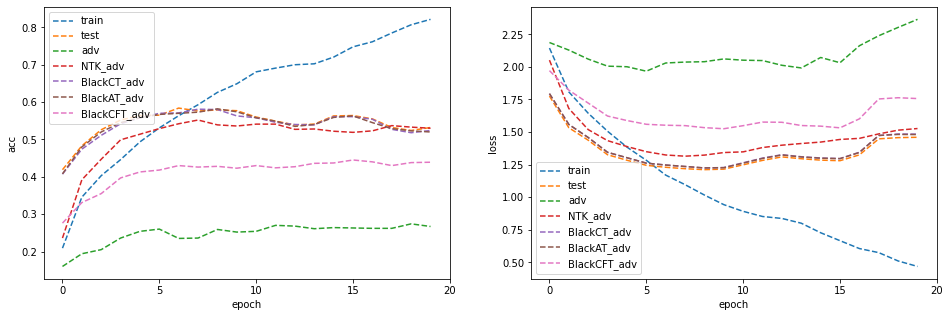

In [28]:
fig = plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(range(len(baseline_train_accuracy_arr)), baseline_train_accuracy_arr, label='train', linestyle='--', color='C0')
plt.plot(range(len(baseline_test_accuracy_arr)), baseline_test_accuracy_arr, label='test', linestyle='--', color='C1')
plt.plot(range(len(baseline_adv_test_accuracy_arr)), baseline_adv_test_accuracy_arr, label='adv', linestyle='--', color='C2')
plt.plot(range(len(NTK_adv_test_accuracy_arr)), NTK_adv_test_accuracy_arr, label='NTK_adv', linestyle='--', color='C3')
plt.plot(range(len(clean_train_from_scratch_accuracy_arr)), clean_train_from_scratch_accuracy_arr, label='BlackCT_adv', linestyle='--', color='C4')
plt.plot(range(len(adv_train_from_scratch_accuracy_arr)), adv_train_from_scratch_accuracy_arr, label='BlackAT_adv', linestyle='--', color='C5')
plt.plot(range(len(CFT_accuracy_arr)), CFT_accuracy_arr, label='BlackCFT_adv', linestyle='--', color='C6')
plt.xticks(range(0,len(baseline_train_accuracy_arr)+1,5))
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(baseline_train_loss_arr)), baseline_train_loss_arr, label='train',linestyle='--', color='C0')
plt.plot(range(len(baseline_test_loss_arr)), baseline_test_loss_arr, label='test', linestyle='--', color='C1')
plt.plot(range(len(baseline_adv_test_loss_arr)), baseline_adv_test_loss_arr, label='adv', linestyle='--', color='C2')
plt.plot(range(len(NTK_adv_test_loss_arr)), NTK_adv_test_loss_arr, label='NTK_adv', linestyle='--', color='C3')
plt.plot(range(len(clean_train_from_scratch_loss_arr)), clean_train_from_scratch_loss_arr, label='BlackCT_adv', linestyle='--', color='C4')
plt.plot(range(len(adv_train_from_scratch_loss_arr)), adv_train_from_scratch_loss_arr, label='BlackAT_adv', linestyle='--', color='C5')
plt.plot(range(len(CFT_loss_arr)), CFT_loss_arr, label='BlackCFT_adv', linestyle='--', color='C6')
plt.xticks(range(0,len(baseline_train_loss_arr)+1,5))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

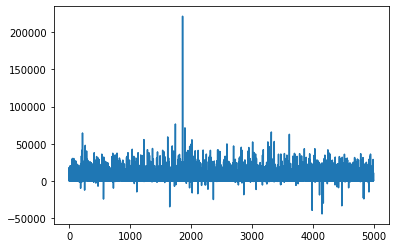

In [29]:
plt.plot(range(len(t_arr)), t_arr)
plt.show()

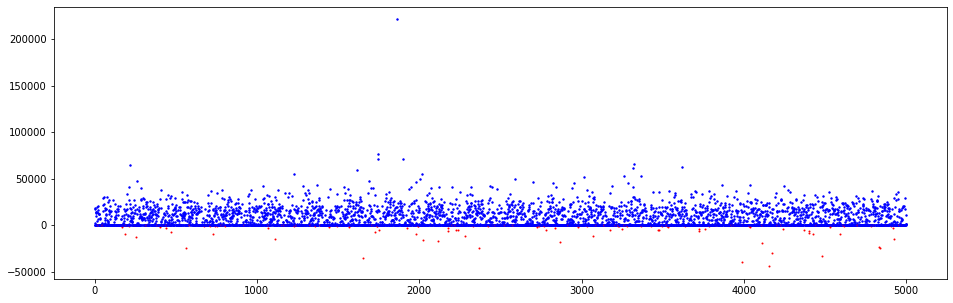

In [30]:
fig, ax = plt.subplots(figsize=(16, 5))
for i, value in enumerate(t_arr):
    if value < 0:
        plt.scatter(i, value, color='red', s=1)
    else:
        plt.scatter(i, value, color='blue', s=2)
plt.show()

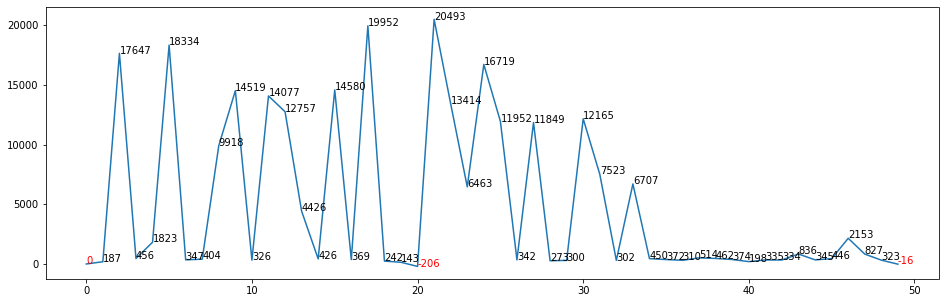

In [31]:
num_of_t_arr = 50
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(range(len(t_arr[:num_of_t_arr])), t_arr[:num_of_t_arr])
# ax.set_yscale('log')

for i, txt in enumerate(t_arr[:num_of_t_arr]):
    if txt <=0:
        ax.annotate('{:.0f}'.format(txt), (i, t_arr[i]), color='red')
    else:
        ax.annotate('{:.0f}'.format(txt), (i, t_arr[i]),)
plt.show()

In [32]:
t_arr

[0.0,
 DeviceArray(187.44918566, dtype=float64),
 DeviceArray(17646.59319137, dtype=float64),
 DeviceArray(456.00413095, dtype=float64),
 DeviceArray(1822.93313965, dtype=float64),
 DeviceArray(18334.40183383, dtype=float64),
 DeviceArray(346.97442409, dtype=float64),
 DeviceArray(404.25815349, dtype=float64),
 DeviceArray(9918.14990544, dtype=float64),
 DeviceArray(14519.20838393, dtype=float64),
 DeviceArray(325.77476037, dtype=float64),
 DeviceArray(14076.63024743, dtype=float64),
 DeviceArray(12756.54850589, dtype=float64),
 DeviceArray(4426.18956966, dtype=float64),
 DeviceArray(425.77409224, dtype=float64),
 DeviceArray(14579.85841425, dtype=float64),
 DeviceArray(369.41530121, dtype=float64),
 DeviceArray(19951.74818253, dtype=float64),
 DeviceArray(242.00901238, dtype=float64),
 DeviceArray(143.31381467, dtype=float64),
 DeviceArray(-205.90464803, dtype=float64),
 DeviceArray(20492.6623964, dtype=float64),
 DeviceArray(13414.10966903, dtype=float64),
 DeviceArray(6462.71581976,

In [33]:
# model.save_weights('NTK-VGG16.h5')